# Analysis of the radiation bias decomposition

In [1]:
%matplotlib inline

import os, sys, copy, glob
import numpy as np
import datetime
import pylab as pl
import xarray as xr
import pandas as pd
import string
import seaborn as sns


In [2]:
from nawdex_analysis.config import nawdex_dir
import nawdex_analysis.io.collector

In [3]:
from  nawdex_analysis.plot.stacked_analysis_plots import hor_barplot_exp_plot
from nawdex_analysis.plot.legend import plegend
import nawdex_analysis.analysis.ave_cre

In [4]:
pl.rcParams['figure.figsize'] = (16.0, 8.0)
pl.rcParams['font.size'] = 18.0
pl.rcParams['lines.linewidth'] = 3


## Read Data

In [5]:
fdir = '%s/statistics' % nawdex_dir
fname = '%s/radflux_decomposition_allsets.nc' % fdir

dset = xr.open_dataset( fname )

## Average Biases 

In [6]:
aveset = dset.sum('ct')
aveset

<xarray.Dataset>
Dimensions:    (component: 6, idname: 16)
Coordinates:
  * idname     (idname) |S17 '10km_oneMom_Conv' ... 'msevi-scaled'
  * component  (component) |S19 'ave_bias' 'cloud_fraction_term' ... 'cre_bias'
Data variables:
    net        (component, idname) float64 5.32 6.09 4.864 ... -4.799 -6.596 0.0
    longwave   (component, idname) float64 6.757 7.676 6.716 ... 8.75 -1.993 0.0
    shortwave  (component, idname) float64 -1.437 -1.585 -1.852 ... -4.603 0.0

## Reshape Bias Data for Plotting

In [7]:
dlist = []
vlist = ['net', 'shortwave', 'longwave']

for vname in vlist:
    d = aveset[vname].expand_dims('var')
    d['var'] = [ vname, ]
    
    dlist += [ d.copy(), ]
dvar = xr.concat( dlist, dim = 'var')
#.rename({'net' : 'biases'})

In [8]:
dcomb = xr.Dataset()
dcomb['abs_bias'] = dvar

dcomb.sel(var = 'net')

<xarray.Dataset>
Dimensions:    (component: 6, idname: 16)
Coordinates:
  * idname     (idname) |S17 '10km_oneMom_Conv' ... 'msevi-scaled'
  * component  (component) |S19 'ave_bias' 'cloud_fraction_term' ... 'cre_bias'
    var        |S3 'net'
Data variables:
    abs_bias   (component, idname) float64 5.32 6.09 4.864 ... -4.799 -6.596 0.0

In [9]:
dcomb.component.data

array(['ave_bias', 'cloud_fraction_term', 'radflux_term', 'cross_term',
       'clear_bias', 'cre_bias'], dtype='|S19')

In [10]:
vlist = ['net', 'shortwave', 'longwave']
complist = ['ave_bias', 'cloud_fraction_term', 'radflux_term', 'cross_term',
       'clear_bias', 'cre_bias']

idlist = list ( dcomb.idname.data )
idlist.remove('msevi-scaled')
idlist.remove('msevi-not_scaled')


## Plot the Bias Decomposition Matrix

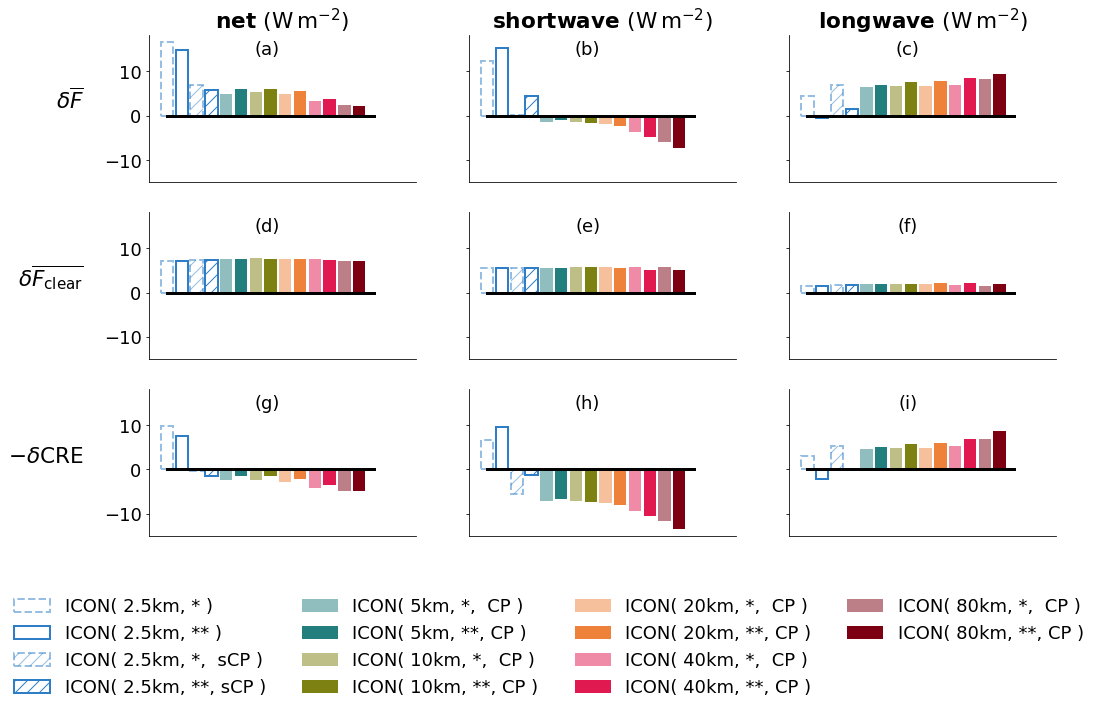

In [14]:
complist = ['ave_bias', 'clear_bias', 'cre_bias']
ylabs = ['$\delta \overline{F}$',
        '$\delta \overline{F_\mathrm{clear}}$', 
         '$-\delta \mathrm{CRE}$']

fig, ax = pl.subplots( nrows = 3, ncols = 3, figsize = (18,12), sharex = True, sharey = True )
pl.subplots_adjust( left = 0.2, bottom = 0.3 )

abc = string.ascii_lowercase

n = 0
for i, compname in enumerate( complist ):
    for j, vname in enumerate( vlist ):
        pl.sca( ax[i,j] )
        hor_barplot_exp_plot( dcomb.sel(var = vname), 'abs_bias', catlist = [compname, ], 
                      icount0 = 0,  idlist = idlist, 
                      iddim='idname', catdim = 'component', 
                      obsref_name='msevi-scaled', doffset=0.05, offset0=-0.4, make_labels=True)
        
        xlim = pl.xlim()
        
        pl.text( (xlim[1] + xlim[0]) / 2., 15, '(%s)' % abc[n], va = 'center', ha = 'center')
        pl.xticks([])
        
        n += 1
        
    

for j, vname in enumerate( vlist ):
    pl.sca( ax[0, j])
    pl.title('%s $(\mathrm{W\,m^{-2}})$' % vname, fontweight = 'bold')
    
for i, compname in enumerate( complist ):
    a = ax[i, 0]
    pl.sca( a )
    
    apos = a.get_position()
    pl.figtext(apos.x0 - 0.05, apos.y0 + apos.height / 2., ylabs[i],
                ha = 'right', fontsize = 'large')

    
## dummy items

pl.sca( ax[2, 1] )
pl.bar([0], [0], color='w', alpha=0, label=' ', zorder = 10)

plegend(loc = 'lower center', ncol = 4, bbox_to_anchor = (0.3, -1.2), fontsize = 'medium' )

sns.despine()
pl.savefig('../pics/rad-bias-decomposition.png', pdi = 300)

### Getting Numbers of Clearsky Biases

The average clearsky bias

In [12]:
dcomb['abs_bias'].sel( idname = idlist, component = 'clear_bias').mean('idname').to_pandas()

var
net          7.419476
shortwave    5.602575
longwave     1.816901
dtype: float64

The standard deviation

In [13]:
dcomb['abs_bias'].sel( idname = idlist, component = 'clear_bias').std('idname').to_pandas()

var
net          0.215512
shortwave    0.182475
longwave     0.231500
dtype: float64